In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [3]:
import fastparquet
def read_data():
    df=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2_gr.parq").to_pandas()
    print df.shape
    return df.drop(['target','fold'],axis=1)
%time df=read_data()

(6582476, 52)
CPU times: user 3.98 s, sys: 1.9 s, total: 5.88 s
Wall time: 5.88 s


In [5]:
df.tail()

rg_market    rg_f_0    rg_f_1    rg_f_2    rg_f_3    rg_f_4  \
id                                                                      
15203950  -0.387262 -0.348419  0.378236  0.058975  0.981253  0.755273   
15203951   0.322468 -0.110367  0.378236 -0.714344 -0.626551 -0.751604   
15203952   0.322468 -0.110367  0.378236 -0.714344 -0.808406 -0.955343   
15203953   0.813589  0.494904  0.378236  0.474373  1.398547  1.570900   
15203954  -0.552426  0.769737 -0.098144  0.058975 -0.566532 -0.500473   

            rg_f_5    rg_f_6    rg_f_7    rg_f_8       ...          rg_f_40  \
id                                                     ...                    
15203950 -0.014614 -0.097357 -0.269295  0.485734       ...        -1.210730   
15203951 -0.669869 -0.097357 -0.947013 -0.222507       ...        -0.019551   
15203952 -0.669869 -0.097357 -0.947013 -0.328080       ...        -0.312326   
15203953  0.498469 -0.097357  0.479370  0.439649       ...         1.699597   
15203954 -0.256815 -0.097357 -0.055516 -0.328080       ...        -0.408059   

           rg_f_41  rg_latest_target  rg_latest3_mean  rg_latest2_mean  \
id                                                                       
15203950 -0.086448          0.007937         0.005797         0.009837   
15203951 -0.126015          0.007937         0.005797         0.009837   
15203952 -0.430338          0.007937         0.005797         0.009837   
15203953  1.654479          0.007937         0.005797         0.009837   
15203954 -0.482392          0.007937         0.005797         0.009837   

          rg_mkt_mean  rg_latest_target_nil  rg_latest3_mean_nil  \
id                                                                 
15203950     0.038103               0.36807             0.133769   
15203951     0.038103               0.36807             0.133769   
15203952     0.038103               0.36807             0.133769   
15203953     0.038103               0.36807             0.133769   
15203954     0.038103               0.36807             0.133769   

          rg_latest2_mean_nil  rg_mkt_mean_nil  
id                                              
15203950             0.230433         0.371281  
15203951             0.230433         0.371281  
15203952             0.230433         0.371281  
15203953             0.230433         0.371281  
15203954             0.230433         0.371281  

[5 rows x 50 columns]

In [6]:
gc.collect()

6706

In [9]:
X=df.values

# cv

In [18]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization, Input
from keras import metrics,backend,regularizers, backend as K, losses, Model
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [28]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [29]:
input_dim=X.shape[1]
input_dim

50

In [322]:
class NoiseLayer(Layer):
    def __init__(self, rate , **kwargs):
        super(NoiseLayer, self).__init__(**kwargs)
        self.rate = min(1., max(0., rate))
        self.supports_masking = True

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            print type(inputs.shape.dims[-1])
            n_col =  inputs.get_shape()[-1].value
            def noise_inputs():
                mask= tf.cast(tf.random_uniform(shape=[1,n_col])<self.rate, tf.float32)#*tf.ones_like(inputs,dtype=tf.float32)
                noise=inputs[0]
                return  inputs*(1-mask)+ noise*mask
            def nonnoise_inputs():
                    return  inputs

                
            return K.in_train_phase(noise_inputs, nonnoise_inputs,
                                    training=training)
        return inputs

    def get_config(self):
        config = {'rate': self.rate }
        base_config = super(NoiseLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*1)       

In [323]:
X.shape,X[:1000].var()

((6582476, 50), 0.36406863)

In [355]:
backend.clear_session()
encoded_layers=[]
input_x = Input(shape=(input_dim,))
encoded=input_x
encoded_layers.append(encoded)
for i in range(3):
    encoded = NoiseLayer(rate=0.3)(encoded)
    encoded = Dense(1024, activation='relu')(encoded)
    encoded_layers.append(encoded)
decoded = Dense(input_dim, activation=None)(encoded)

<class 'tensorflow.python.framework.tensor_shape.Dimension'>
<class 'tensorflow.python.framework.tensor_shape.Dimension'>
<class 'tensorflow.python.framework.tensor_shape.Dimension'>


In [356]:
stacked=keras.layers.concatenate(encoded_layers)

In [357]:
autoencoder = Model(input_x, decoded)

In [358]:
#SVG(model_to_dot(autoencoder,show_shapes=True).create(prog='dot', format='svg'))

In [359]:
stacker=Model(input_x,stacked)

In [360]:
#SVG(model_to_dot(stacker,show_shapes=True).create(prog='dot', format='svg'))

In [361]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.6
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return max(lrate,1e-3)

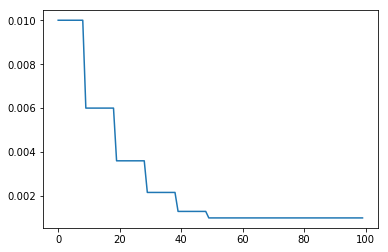

In [362]:
plt.plot(range(100),[step_decay(u) for u in range(100)]);

In [363]:
sgd=keras.optimizers.SGD(lr=0.01, momentum=0., decay=0., nesterov=False)
autoencoder.compile(optimizer=sgd, loss='mean_squared_error')

In [364]:
#0.30,  
from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping,lrate],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.3214 - val_loss: 0.2168
Epoch 2/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.3045 - val_loss: 0.1855
Epoch 3/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.2991 - val_loss: 0.1675
Epoch 4/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.2949 - val_loss: 0.1525
Epoch 5/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.2931 - val_loss: 0.1443
Epoch 6/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.2918 - val_loss: 0.1438
Epoch 7/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.2891 - val_loss: 0.1399
Epoch 8/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.2877 - val_loss: 0.1416
Epoch 9/50
5924228/5924228 [==============================] - 72s 1

In [344]:
#0.20, 
from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping,lrate],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2507 - val_loss: 0.1463
Epoch 2/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2202 - val_loss: 0.0990
Epoch 3/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2107 - val_loss: 0.0727
Epoch 4/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2070 - val_loss: 0.0605
Epoch 5/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2040 - val_loss: 0.0506
Epoch 6/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2032 - val_loss: 0.0437
Epoch 7/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.2009 - val_loss: 0.0398
Epoch 8/50
5924228/5924228 [==============================] - 73s 12us/step - loss: 0.1995 - val_loss: 0.0359
Epoch 9/50
5924228/5924228 [==============================] - 73s 1

In [354]:
#0.10,  
from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping,lrate],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.1728 - val_loss: 0.1178
Epoch 2/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.1069 - val_loss: 0.0634
Epoch 3/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.0928 - val_loss: 0.0394
Epoch 4/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.0880 - val_loss: 0.0286
Epoch 5/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.0857 - val_loss: 0.0243
Epoch 6/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.0840 - val_loss: 0.0232
Epoch 7/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.0827 - val_loss: 0.0214
Epoch 8/50
5924228/5924228 [==============================] - 72s 12us/step - loss: 0.0827 - val_loss: 0.0198
Epoch 9/50
5924228/5924228 [==============================] - 72s 1

In [ ]:
#0.20, sgd
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

In [222]:
#0.20, zero noise, null encoding
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 107s 18us/step - loss: 0.0639 - val_loss: 0.0768
Epoch 2/50
5924228/5924228 [==============================] - 107s 18us/step - loss: 0.0408 - val_loss: 0.0672
Epoch 3/50
5924228/5924228 [==============================] - 106s 18us/step - loss: 0.0368 - val_loss: 0.0527
Epoch 4/50
5924228/5924228 [==============================] - 106s 18us/step - loss: 0.0343 - val_loss: 0.0467
Epoch 5/50
5924228/5924228 [==============================] - 106s 18us/step - loss: 0.0329 - val_loss: 0.0451
Epoch 6/50
5924228/5924228 [==============================] - 107s 18us/step - loss: 0.0321 - val_loss: 0.0453
Epoch 7/50
5924228/5924228 [==============================] - 106s 18us/step - loss: 0.0313 - val_loss: 0.0493
Epoch 8/50
5924228/5924228 [==============================] - 106s 18us/step - loss: 0.0306 - val_loss: 0.0505


In [151]:
#0.20, zero noise
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 79s 13us/step - loss: 0.0432 - val_loss: 0.0532
Epoch 2/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0323 - val_loss: 0.0380
Epoch 3/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0293 - val_loss: 0.0280
Epoch 4/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0277 - val_loss: 0.0419
Epoch 5/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0262 - val_loss: 0.0233
Epoch 6/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0252 - val_loss: 0.0185
Epoch 7/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0248 - val_loss: 0.0213
Epoch 8/50
5924228/5924228 [==============================] - 78s 13us/step - loss: 0.0243 - val_loss: 0.0201
Epoch 9/50
5924228/5924228 [==============================] - 78s 1

In [169]:
#0.20,   only input layer
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 76s 13us/step - loss: 0.1001 - val_loss: 0.0488
Epoch 2/50
5924228/5924228 [==============================] - 76s 13us/step - loss: 0.0837 - val_loss: 0.0381
Epoch 3/50
5924228/5924228 [==============================] - 77s 13us/step - loss: 0.0778 - val_loss: 0.0303
Epoch 4/50
5924228/5924228 [==============================] - 76s 13us/step - loss: 0.0735 - val_loss: 0.0297
Epoch 5/50
5924228/5924228 [==============================] - 77s 13us/step - loss: 0.0706 - val_loss: 0.0273
Epoch 6/50
5924228/5924228 [==============================] - 76s 13us/step - loss: 0.0706 - val_loss: 0.0262
Epoch 7/50
5924228/5924228 [==============================] - 76s 13us/step - loss: 0.0690 - val_loss: 0.0243
Epoch 8/50
5924228/5924228 [==============================] - 77s 13us/step - loss: 0.0672 - val_loss: 0.0255
Epoch 9/50
5924228/5924228 [==============================] - 76s 1

In [140]:
0.20
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 82s 14us/step - loss: 0.2323 - val_loss: 0.1909
Epoch 2/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.1821 - val_loss: 0.1029
Epoch 3/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.1620 - val_loss: 0.1231
Epoch 4/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.1509 - val_loss: 0.0785
Epoch 5/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.1458 - val_loss: 0.0869
Epoch 6/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.1410 - val_loss: 0.0812
Epoch 7/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.1358 - val_loss: 0.0907


In [132]:
0.15
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 84s 14us/step - loss: 0.1707 - val_loss: 0.1304
Epoch 2/50
5924228/5924228 [==============================] - 85s 14us/step - loss: 0.1353 - val_loss: 0.0821
Epoch 3/50
5924228/5924228 [==============================] - 84s 14us/step - loss: 0.1177 - val_loss: 0.0535
Epoch 4/50
5924228/5924228 [==============================] - 84s 14us/step - loss: 0.1088 - val_loss: 0.0514
Epoch 5/50
5924228/5924228 [==============================] - 85s 14us/step - loss: 0.1032 - val_loss: 0.0657
Epoch 6/50
5924228/5924228 [==============================] - 84s 14us/step - loss: 0.1015 - val_loss: 0.0600


In [122]:
0.05
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0468 - val_loss: 0.0243
Epoch 2/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0366 - val_loss: 0.0199
Epoch 3/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0333 - val_loss: 0.0184
Epoch 4/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0309 - val_loss: 0.0181
Epoch 5/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0297 - val_loss: 0.0182
Epoch 6/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0290 - val_loss: 0.0367


In [111]:
0.10
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
batch_size=1024
history=autoencoder.fit(X, X, batch_size=batch_size,epochs=50, validation_split=0.1, 
               callbacks=[early_stopping],verbose=1,shuffle=True)

Train on 5924228 samples, validate on 658248 samples
Epoch 1/50
5924228/5924228 [==============================] - 82s 14us/step - loss: 0.0811 - val_loss: 0.0654
Epoch 2/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0715 - val_loss: 0.0339
Epoch 3/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0666 - val_loss: 0.0309
Epoch 4/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0639 - val_loss: 0.0321
Epoch 5/50
5924228/5924228 [==============================] - 81s 14us/step - loss: 0.0624 - val_loss: 0.0628


In [13]:
def cqwk_error(y_true, y_pred):
    M=K.constant(4.593761,dtype=tf.float32)
    y_true_zeromean=y_true-M
    y_pred_zeromean=y_pred-M
    covab=tf.reduce_mean(y_pred_zeromean*y_true_zeromean)
    vara=tf.reduce_mean(y_true_zeromean*y_true_zeromean)
    varb=tf.reduce_mean(y_pred_zeromean*y_pred_zeromean)
    return K.constant(-2,dtype=tf.float32)*covab/(vara+varb)
def epsilon_loss(y_true,y_pred,epsilon):
     return tf.reduce_mean(tf.maximum(0., tf.abs(y_pred-y_true)-epsilon))
def epsilon_squared_loss(y_true,y_pred,epsilon):
     return tf.reduce_mean(tf.maximum(0., tf.abs(y_pred-y_true)-epsilon)**2)

In [14]:
class KerasModel:
    def __init__(self,params={}):
        self.params=params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        if 'use_kernel' in params  and params['use_kernel']:
            model.add(KernelLayer(params['components'],params["normalization"],params['kernel'],
                                  params['gamma'],params['degree']))
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss='mean_squared_error'
            if params['metric']=="mean_squared_error":
                this_metrics=[metrics.mean_squared_error]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'cqwk_error':
            model.add(Dense(1,activation=None))
            this_loss=cqwk_error
            if params['metric']=="cqwk_error":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'epsilon_loss':
            epsilon = K.constant([params['epsilon']])
            model.add(Dense(1,activation=None))
            def this_loss(u,v):
                return epsilon_loss(u,v,epsilon)
            if params['metric']=="cqwk_error":
                this_metrics=[cqwk_error]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'epsilon_squared_loss':
            epsilon = K.constant([params['epsilon']])
            model.add(Dense(1,activation=None))
            def this_loss(u,v):
                return epsilon_squared_loss(u,v,epsilon)
            if params['metric']=="cqwk_error":
                this_metrics=[cqwk_error]
            else:
                raise Exception("unknown")
        elif  params['loss'] ==  'categorical_crossentropy':            
            model.add(Dense(21, activation='softmax'))
            this_loss='categorical_crossentropy'
            if params['metric']=="categorical_crossentropy":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif  params['loss'] ==  'categorical_mse':            
            model.add(Dense(21, activation='softmax'))
            this_loss=lambda u,v: categorical_mean_squared_error(u,v)
            if params['metric']=="categorical_mse":
                this_metrics=[categorical_mean_squared_error]
            else:
                raise Exception("unknown")                
        elif  params['loss'] ==  'categorical_mix':            
            model.add(Dense(21, activation='softmax'))
            this_loss=lambda u,v: 0.5*categorical_mean_squared_error(u,v)+losses.categorical_crossentropy(u,v)
            if params['metric']=="categorical_mix":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")                
                
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
          metrics=this_metrics)

        self.model=model
        return self
    def fit(self,X,y,epochs=200):
        params=self.params
        validation_split=params['validation_split']
        patience=params['patience']
        if params['loss'] ==  'categorical_crossentropy'        :
            y=keras.utils.to_categorical(y, num_classes=21)
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        print "earlystopping on "+metric_name
        early_stopping = EarlyStopping(monitor='val_'+metric_name, patience=patience)
        batch_size=params['batch_size']
        history=self.model.fit(X, y, batch_size=batch_size,epochs=epochs, validation_split=validation_split, 
                       callbacks=[early_stopping],verbose=2)
        return history

In [15]:


def make_tf_kernel(X,compoents, normalization, kernel='rbf',gamma=0.1,degree=3):
    components=K.constant(compoents,dtype=tf.float32)
    normalization=K.constant(normalization.T,dtype=tf.float32)
    if kernel=='rbf':
        X=K.expand_dims(X,axis=1)
        def f(x):
            d=x-compoents
            return K.exp(-gamma*K.sum((d**2),axis=1))
        embeded=K.map_fn(f,X,dtype=tf.float32)
        return tf.matmul(embeded,normalization)
    elif kernel=='polynomial':
        def f():
            xy=tf.matmul(X,tf.transpose(compoents))
            return tf.pow(gamma*xy+1,degree)
        embeded=f()
        return tf.matmul(embeded,normalization)
    elif kernel=='sigmoid':
        def f():
            xy=tf.matmul(X,tf.transpose(compoents))
            return tf.tanh(gamma*xy+1)
        embeded=f()
        return tf.matmul(embeded,normalization)    
    else:
        raise Exception("unknown")        

        
class KernelLayer(Layer):

    def __init__(self, components, normalization, kernel='rbf',gamma=0.1,degree=3,  **kwargs):
        assert kernel in ['rbf','sigmoid','polynomial']
        self.components=components
        self.n_components=components.shape[0]
        self.normalization=normalization        
        self.kernel=kernel
        self.gamma=gamma
        self.degree=degree
        super(KernelLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(KernelLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return make_tf_kernel(x,self.components,self.normalization,kernel=self.kernel,gamma=self.gamma,degree=self.degree)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)   

In [16]:
if 1:
    a=make_kernel(X,n=100,gamma=0.002)
    sx=X[:1000]
    r1=a.transform(sx)
    with tf.Session() as sess:
        X_placeholder=tf.placeholder(tf.float32,shape=[None,150])
        tfk=make_tf_kernel(X_placeholder,a.components_, a.normalization_, kernel='rbf',gamma=0.002)
        r2=sess.run(tfk,feed_dict={X_placeholder:sx})
    print np.abs(r1-r2).max()
    assert np.abs(r1-r2).max()< 1e-5

3.8743e-06


In [19]:
if 1:
    a=make_kernel(X,n=100,kernel='polynomial', gamma=0.002, degree=3)
    sx=X[:1000]
    r1=a.transform(sx)
    with tf.Session() as sess:
        X_placeholder=tf.placeholder(tf.float32,shape=[None,150])
        tfk=make_tf_kernel(X_placeholder,a.components_, a.normalization_, kernel='polynomial',gamma=0.002,degree=3)
        r2=sess.run(tfk,feed_dict={X_placeholder:sx})
    print np.abs(r1-r2).max()        
    assert np.abs(r1-r2).max()< 1e-5

6.19888e-06


In [20]:
if 1:
    a=make_kernel(X,n=100,kernel='sigmoid', gamma=0.002, degree=3)
    sx=X[1000:2000]
    r1=a.transform(sx)
    with tf.Session() as sess:
        X_placeholder=tf.placeholder(tf.float32,shape=[None,150])
        tfk=make_tf_kernel(X_placeholder,a.components_, a.normalization_, kernel='sigmoid',gamma=0.002,degree=3)
        r2=sess.run(tfk,feed_dict={X_placeholder:sx})
    print np.abs(r1-r2).max()        
    assert np.abs(r1-r2).max()< 1e-4

1.32918e-05


In [21]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [22]:
param_grid={'input_dim':[(input_dim,)],
            'batch_size':[256,512],
            'hidden_layer_sizes': [(128,),(128,128),(128,128,128)],
            'metric':['mean_squared_error'],
            'loss':['mean_squared_error'],
            "validation_split":[0.2],"patience":[3],
            "dropout_rate":[0.0,0.2],
            "activation":['relu','sigmoid'],    
            "l2":[0,1e-4,1e-3],
            'batch_normalization': [True],
            "optimizer":['adam','rmsprop','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
len(parameters)

216

In [23]:
parameter=parameters[0]
parameter

{'activation': 'relu',
 'batch_normalization': True,
 'batch_size': 256,
 'dropout_rate': 0.0,
 'hidden_layer_sizes': (128,),
 'input_dim': (150,),
 'l2': 0,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.2}

In [24]:
def run_once(parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    K_CONST=K.constant(np.array([range(21)]),dtype=tf.float32)
    a=KerasModel(parameter)
    a._make_model()
    h=a.fit(X,y)
    return [parameter,h.history]

In [34]:
if 0:
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    SVG(model_to_dot(a.model).create(prog='dot', format='svg'))

In [35]:
import cPickle as pickle

In [ ]:
lst=[]
for parameter in parameters:
    print parameter
    h=run_once(parameter)
    lst.append(h)
    pickle.dump(lst,open("mlp_sel.pkl",'wb'))

{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adam', 'hidden_layer_sizes': (128,), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 115s - loss: 3.7013 - mean_squared_error: 3.7013 - val_loss: 3.6195 - val_mean_squared_error: 3.6195
Epoch 2/200
 - 115s - loss: 3.6379 - mean_squared_error: 3.6379 - val_loss: 3.6048 - val_mean_squared_error: 3.6048
Epoch 3/200
 - 115s - loss: 3.6249 - mean_squared_error: 3.6249 - val_loss: 3.6208 - val_mean_squared_error: 3.6208
Epoch 4/200
 - 114s - loss: 3.6180 - mean_squared_error: 3.6180 - val_loss: 3.6048 - val_mean_squared_error: 3.6048
Epoch 5/200
 - 114s - loss: 3.6132 - mean_squared_error: 3.6132 - val_loss: 3.6048 - val_mean_squared_error: 3.6048
Epoch 6/200
 - 116s - loss: 3.6106 - mean_squared_error

Epoch 7/200
 - 110s - loss: 3.6290 - mean_squared_error: 3.6163 - val_loss: 3.6223 - val_mean_squared_error: 3.6097
Epoch 8/200
 - 110s - loss: 3.6261 - mean_squared_error: 3.6135 - val_loss: 3.6185 - val_mean_squared_error: 3.6060
Epoch 9/200
 - 110s - loss: 3.6242 - mean_squared_error: 3.6117 - val_loss: 3.6140 - val_mean_squared_error: 3.6016
Epoch 10/200
 - 109s - loss: 3.6221 - mean_squared_error: 3.6098 - val_loss: 3.6313 - val_mean_squared_error: 3.6190
Epoch 11/200
 - 108s - loss: 3.6212 - mean_squared_error: 3.6089 - val_loss: 3.6176 - val_mean_squared_error: 3.6054
Epoch 12/200
 - 108s - loss: 3.6199 - mean_squared_error: 3.6077 - val_loss: 3.6235 - val_mean_squared_error: 3.6113
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adam', 'hidden_layer_sizes': (128,), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0.001, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_

Epoch 8/200
 - 134s - loss: 3.5962 - mean_squared_error: 3.5962 - val_loss: 3.5960 - val_mean_squared_error: 3.5960
Epoch 9/200
 - 135s - loss: 3.5947 - mean_squared_error: 3.5947 - val_loss: 3.5961 - val_mean_squared_error: 3.5961
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adam', 'hidden_layer_sizes': (128, 128), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0.0001, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 153s - loss: 3.7248 - mean_squared_error: 3.6986 - val_loss: 3.6457 - val_mean_squared_error: 3.6220
Epoch 2/200
 - 154s - loss: 3.6586 - mean_squared_error: 3.6362 - val_loss: 3.6286 - val_mean_squared_error: 3.6074
Epoch 3/200
 - 153s - loss: 3.6457 - mean_squared_error: 3.6256 - val_loss: 3.6234 - val_mean_squared_error: 3.6045
Epoch 4/200
 - 155s - loss: 3.6369 - mean_squa

Epoch 7/200
 - 138s - loss: 3.6665 - mean_squared_error: 3.5949 - val_loss: 3.6652 - val_mean_squared_error: 3.5962
Epoch 8/200
 - 137s - loss: 3.6588 - mean_squared_error: 3.5921 - val_loss: 3.6599 - val_mean_squared_error: 3.5953
Epoch 9/200
 - 139s - loss: 3.6520 - mean_squared_error: 3.5894 - val_loss: 3.6566 - val_mean_squared_error: 3.5958
Epoch 10/200
 - 139s - loss: 3.6470 - mean_squared_error: 3.5879 - val_loss: 3.6540 - val_mean_squared_error: 3.5965
Epoch 11/200
 - 139s - loss: 3.6426 - mean_squared_error: 3.5865 - val_loss: 3.6453 - val_mean_squared_error: 3.5906
Epoch 12/200
 - 138s - loss: 3.6382 - mean_squared_error: 3.5848 - val_loss: 3.6436 - val_mean_squared_error: 3.5914
Epoch 13/200
 - 139s - loss: 3.6343 - mean_squared_error: 3.5833 - val_loss: 3.6384 - val_mean_squared_error: 3.5884
Epoch 14/200
 - 139s - loss: 3.6312 - mean_squared_error: 3.5822 - val_loss: 3.6392 - val_mean_squared_error: 3.5911
Epoch 15/200
 - 139s - loss: 3.6279 - mean_squared_error: 3.5807 - 

Epoch 6/200
 - 178s - loss: 3.6405 - mean_squared_error: 3.6178 - val_loss: 3.6244 - val_mean_squared_error: 3.6020
Epoch 7/200
 - 180s - loss: 3.6375 - mean_squared_error: 3.6152 - val_loss: 3.6390 - val_mean_squared_error: 3.6170
Epoch 8/200
 - 181s - loss: 3.6352 - mean_squared_error: 3.6133 - val_loss: 3.6130 - val_mean_squared_error: 3.5912
Epoch 9/200
 - 181s - loss: 3.6328 - mean_squared_error: 3.6111 - val_loss: 3.6199 - val_mean_squared_error: 3.5984
Epoch 10/200
 - 180s - loss: 3.6310 - mean_squared_error: 3.6097 - val_loss: 3.6171 - val_mean_squared_error: 3.5960
Epoch 11/200
 - 178s - loss: 3.6306 - mean_squared_error: 3.6096 - val_loss: 3.6219 - val_mean_squared_error: 3.6010
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adagrad', 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0.0001, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopp

Epoch 6/200
 - 130s - loss: 3.6674 - mean_squared_error: 3.6674 - val_loss: 3.6056 - val_mean_squared_error: 3.6056
Epoch 7/200
 - 131s - loss: 3.6663 - mean_squared_error: 3.6663 - val_loss: 3.6004 - val_mean_squared_error: 3.6004
Epoch 8/200
 - 132s - loss: 3.6639 - mean_squared_error: 3.6639 - val_loss: 3.6254 - val_mean_squared_error: 3.6254
Epoch 9/200
 - 130s - loss: 3.6619 - mean_squared_error: 3.6619 - val_loss: 3.6051 - val_mean_squared_error: 3.6051
Epoch 10/200
 - 133s - loss: 3.6612 - mean_squared_error: 3.6612 - val_loss: 3.6074 - val_mean_squared_error: 3.6074
{'loss': 'mean_squared_error', 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'hidden_layer_sizes': (128,), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 119s - loss: 3.8018 - mean_squared_e

Epoch 9/200
 - 114s - loss: 3.7257 - mean_squared_error: 3.7142 - val_loss: 3.6148 - val_mean_squared_error: 3.6033
Epoch 10/200
 - 115s - loss: 3.7230 - mean_squared_error: 3.7117 - val_loss: 3.6138 - val_mean_squared_error: 3.6025
Epoch 11/200
 - 114s - loss: 3.7203 - mean_squared_error: 3.7091 - val_loss: 3.6110 - val_mean_squared_error: 3.5998
Epoch 12/200
 - 114s - loss: 3.7166 - mean_squared_error: 3.7054 - val_loss: 3.6117 - val_mean_squared_error: 3.6006
Epoch 13/200
 - 114s - loss: 3.7159 - mean_squared_error: 3.7048 - val_loss: 3.6104 - val_mean_squared_error: 3.5994
Epoch 14/200
 - 114s - loss: 3.7110 - mean_squared_error: 3.7000 - val_loss: 3.6101 - val_mean_squared_error: 3.5992
Epoch 15/200
 - 114s - loss: 3.7088 - mean_squared_error: 3.6979 - val_loss: 3.6089 - val_mean_squared_error: 3.5981
Epoch 16/200
 - 115s - loss: 3.7111 - mean_squared_error: 3.7003 - val_loss: 3.6096 - val_mean_squared_error: 3.5988
Epoch 17/200
 - 115s - loss: 3.7077 - mean_squared_error: 3.6970 

Epoch 4/200
 - 149s - loss: 3.6856 - mean_squared_error: 3.6856 - val_loss: 3.6472 - val_mean_squared_error: 3.6472
Epoch 5/200
 - 150s - loss: 3.6809 - mean_squared_error: 3.6809 - val_loss: 3.7035 - val_mean_squared_error: 3.7035
Epoch 6/200
 - 189s - loss: 3.6764 - mean_squared_error: 3.6764 - val_loss: 3.6288 - val_mean_squared_error: 3.6288
Epoch 7/200
 - 223s - loss: 3.6734 - mean_squared_error: 3.6734 - val_loss: 3.6124 - val_mean_squared_error: 3.6124
Epoch 8/200
 - 154s - loss: 3.6720 - mean_squared_error: 3.6720 - val_loss: 3.6437 - val_mean_squared_error: 3.6437
Epoch 9/200
 - 161s - loss: 3.6708 - mean_squared_error: 3.6708 - val_loss: 3.6871 - val_mean_squared_error: 3.6871
Epoch 10/200
 - 161s - loss: 3.6698 - mean_squared_error: 3.6698 - val_loss: 3.6233 - val_mean_squared_error: 3.6233
{'loss': 'mean_squared_error', 'dropout_rate': 0.2, 'optimizer': 'adagrad', 'hidden_layer_sizes': (128, 128), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0, 'input_dim':

Epoch 2/200
 - 148s - loss: 3.8873 - mean_squared_error: 3.7616 - val_loss: 3.7569 - val_mean_squared_error: 3.6472
Epoch 3/200
 - 147s - loss: 3.8368 - mean_squared_error: 3.7380 - val_loss: 3.7283 - val_mean_squared_error: 3.6387
Epoch 4/200
 - 148s - loss: 3.8066 - mean_squared_error: 3.7239 - val_loss: 3.7151 - val_mean_squared_error: 3.6386
Epoch 5/200
 - 149s - loss: 3.7871 - mean_squared_error: 3.7155 - val_loss: 3.6839 - val_mean_squared_error: 3.6166
Epoch 6/200
 - 149s - loss: 3.7697 - mean_squared_error: 3.7060 - val_loss: 3.6828 - val_mean_squared_error: 3.6225
Epoch 7/200
 - 148s - loss: 3.7587 - mean_squared_error: 3.7012 - val_loss: 3.6720 - val_mean_squared_error: 3.6171
Epoch 8/200
 - 149s - loss: 3.7488 - mean_squared_error: 3.6961 - val_loss: 3.6785 - val_mean_squared_error: 3.6280
{'loss': 'mean_squared_error', 'dropout_rate': 0.2, 'optimizer': 'adam', 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu', 'batch_size': 256, 'patience': 3, 'l2': 0, 'input_dim'

 - 201s - loss: 3.8277 - mean_squared_error: 3.7901 - val_loss: 3.6926 - val_mean_squared_error: 3.6559
Epoch 3/200
 - 196s - loss: 3.8035 - mean_squared_error: 3.7675 - val_loss: 3.6610 - val_mean_squared_error: 3.6257
Epoch 4/200
 - 204s - loss: 3.7876 - mean_squared_error: 3.7529 - val_loss: 3.6537 - val_mean_squared_error: 3.6196
Epoch 5/200
 - 193s - loss: 3.7781 - mean_squared_error: 3.7445 - val_loss: 3.6586 - val_mean_squared_error: 3.6255
Epoch 6/200
 - 191s - loss: 3.7685 - mean_squared_error: 3.7358 - val_loss: 3.6529 - val_mean_squared_error: 3.6206
Epoch 7/200
 - 191s - loss: 3.7619 - mean_squared_error: 3.7301 - val_loss: 3.6455 - val_mean_squared_error: 3.6140
Epoch 8/200
 - 191s - loss: 3.7573 - mean_squared_error: 3.7263 - val_loss: 3.6443 - val_mean_squared_error: 3.6136
Epoch 9/200
 - 190s - loss: 3.7513 - mean_squared_error: 3.7209 - val_loss: 3.6399 - val_mean_squared_error: 3.6098
Epoch 10/200
 - 191s - loss: 3.7463 - mean_squared_error: 3.7165 - val_loss: 3.6366 

Epoch 8/200
 - 68s - loss: 3.6021 - mean_squared_error: 3.6021 - val_loss: 3.6025 - val_mean_squared_error: 3.6025
Epoch 9/200
 - 68s - loss: 3.6010 - mean_squared_error: 3.6010 - val_loss: 3.6531 - val_mean_squared_error: 3.6531
Epoch 10/200
 - 68s - loss: 3.6005 - mean_squared_error: 3.6005 - val_loss: 3.6983 - val_mean_squared_error: 3.6983
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adagrad', 'hidden_layer_sizes': (128,), 'activation': 'relu', 'batch_size': 512, 'patience': 3, 'l2': 0, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 68s - loss: 3.6799 - mean_squared_error: 3.6799 - val_loss: 3.6324 - val_mean_squared_error: 3.6324
Epoch 2/200
 - 68s - loss: 3.6360 - mean_squared_error: 3.6360 - val_loss: 3.6231 - val_mean_squared_error: 3.6231
Epoch 3/200
 - 68s - loss: 3.6263 - mean_squared_error: 

 - 72s - loss: 3.6330 - mean_squared_error: 3.6187 - val_loss: 3.6262 - val_mean_squared_error: 3.6120
Epoch 9/200
 - 73s - loss: 3.6319 - mean_squared_error: 3.6182 - val_loss: 3.6184 - val_mean_squared_error: 3.6049
Epoch 10/200
 - 74s - loss: 3.6306 - mean_squared_error: 3.6173 - val_loss: 3.6167 - val_mean_squared_error: 3.6037
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'rmsprop', 'hidden_layer_sizes': (128,), 'activation': 'relu', 'batch_size': 512, 'patience': 3, 'l2': 0.001, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 74s - loss: 3.7540 - mean_squared_error: 3.6994 - val_loss: 3.6814 - val_mean_squared_error: 3.6537
Epoch 2/200
 - 74s - loss: 3.6618 - mean_squared_error: 3.6387 - val_loss: 3.7061 - val_mean_squared_error: 3.6860
Epoch 3/200
 - 74s - loss: 3.6514 - mean_squared_error: 3.6321 -

Epoch 11/200
 - 91s - loss: 3.5862 - mean_squared_error: 3.5862 - val_loss: 3.5935 - val_mean_squared_error: 3.5935
Epoch 12/200
 - 90s - loss: 3.5843 - mean_squared_error: 3.5843 - val_loss: 3.5946 - val_mean_squared_error: 3.5946
Epoch 13/200
 - 90s - loss: 3.5832 - mean_squared_error: 3.5832 - val_loss: 3.5946 - val_mean_squared_error: 3.5946
Epoch 14/200
 - 90s - loss: 3.5823 - mean_squared_error: 3.5823 - val_loss: 3.5999 - val_mean_squared_error: 3.5999
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adam', 'hidden_layer_sizes': (128, 128), 'activation': 'relu', 'batch_size': 512, 'patience': 3, 'l2': 0.0001, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 103s - loss: 3.7171 - mean_squared_error: 3.6909 - val_loss: 3.6726 - val_mean_squared_error: 3.6484
Epoch 2/200
 - 102s - loss: 3.6490 - mean_squa

Epoch 3/200
 - 93s - loss: 3.7196 - mean_squared_error: 3.6035 - val_loss: 3.7094 - val_mean_squared_error: 3.6020
Epoch 4/200
 - 93s - loss: 3.6981 - mean_squared_error: 3.5975 - val_loss: 3.7007 - val_mean_squared_error: 3.6061
Epoch 5/200
 - 93s - loss: 3.6826 - mean_squared_error: 3.5929 - val_loss: 3.6887 - val_mean_squared_error: 3.6035
Epoch 6/200
 - 93s - loss: 3.6711 - mean_squared_error: 3.5897 - val_loss: 3.6813 - val_mean_squared_error: 3.6034
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adam', 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu', 'batch_size': 512, 'patience': 3, 'l2': 0, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 122s - loss: 3.6828 - mean_squared_error: 3.6828 - val_loss: 3.6167 - val_mean_squared_error: 3.6167
Epoch 2/200
 - 123s - loss: 3.6263 - mean_squared_

Epoch 7/200
 - 106s - loss: 3.6274 - mean_squared_error: 3.6072 - val_loss: 3.6287 - val_mean_squared_error: 3.6087
Epoch 8/200
 - 106s - loss: 3.6245 - mean_squared_error: 3.6046 - val_loss: 3.6302 - val_mean_squared_error: 3.6104
Epoch 9/200
 - 106s - loss: 3.6222 - mean_squared_error: 3.6025 - val_loss: 3.6282 - val_mean_squared_error: 3.6087
Epoch 10/200
 - 106s - loss: 3.6196 - mean_squared_error: 3.6003 - val_loss: 3.6861 - val_mean_squared_error: 3.6669
{'loss': 'mean_squared_error', 'dropout_rate': 0.0, 'optimizer': 'adagrad', 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu', 'batch_size': 512, 'patience': 3, 'l2': 0.0001, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 104s - loss: 3.6994 - mean_squared_error: 3.6597 - val_loss: 3.6589 - val_mean_squared_error: 3.6203
Epoch 2/200
 - 104s - loss: 3.6530 - 

Epoch 8/200
 - 75s - loss: 3.6528 - mean_squared_error: 3.6528 - val_loss: 3.6001 - val_mean_squared_error: 3.6001
Epoch 9/200
 - 74s - loss: 3.6502 - mean_squared_error: 3.6502 - val_loss: 3.6058 - val_mean_squared_error: 3.6058
{'loss': 'mean_squared_error', 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'hidden_layer_sizes': (128,), 'activation': 'relu', 'batch_size': 512, 'patience': 3, 'l2': 0, 'input_dim': (150,), 'validation_split': 0.2, 'batch_normalization': True, 'metric': 'mean_squared_error'}
earlystopping on mean_squared_error
Train on 4163164 samples, validate on 1040791 samples
Epoch 1/200
 - 72s - loss: 3.8145 - mean_squared_error: 3.8145 - val_loss: 3.6370 - val_mean_squared_error: 3.6370
Epoch 2/200
 - 72s - loss: 3.7070 - mean_squared_error: 3.7070 - val_loss: 3.6938 - val_mean_squared_error: 3.6938
Epoch 3/200
 - 72s - loss: 3.6859 - mean_squared_error: 3.6859 - val_loss: 3.6220 - val_mean_squared_error: 3.6220
Epoch 4/200
 - 72s - loss: 3.6725 - mean_squared_error: 3

 - 71s - loss: 3.7049 - mean_squared_error: 3.6940 - val_loss: 3.6082 - val_mean_squared_error: 3.5974
Epoch 15/200
 - 71s - loss: 3.7022 - mean_squared_error: 3.6914 - val_loss: 3.6071 - val_mean_squared_error: 3.5963
Epoch 16/200
 - 71s - loss: 3.6993 - mean_squared_error: 3.6886 - val_loss: 3.6076 - val_mean_squared_error: 3.5969
Epoch 17/200
 - 71s - loss: 3.6994 - mean_squared_error: 3.6887 - val_loss: 3.6064 - val_mean_squared_error: 3.5958
Epoch 18/200
 - 71s - loss: 3.6957 - mean_squared_error: 3.6851 - val_loss: 3.6047 - val_mean_squared_error: 3.5942
Epoch 19/200
 - 71s - loss: 3.6960 - mean_squared_error: 3.6855 - val_loss: 3.6045 - val_mean_squared_error: 3.5940
Epoch 20/200
 - 71s - loss: 3.6944 - mean_squared_error: 3.6839 - val_loss: 3.6063 - val_mean_squared_error: 3.5959
Epoch 21/200
 - 71s - loss: 3.6929 - mean_squared_error: 3.6825 - val_loss: 3.6047 - val_mean_squared_error: 3.5944
Epoch 22/200
 - 71s - loss: 3.6936 - mean_squared_error: 3.6833 - val_loss: 3.6034 - 

Epoch 14/200
 - 70s - loss: 3.7192 - mean_squared_error: 3.6941 - val_loss: 3.6261 - val_mean_squared_error: 3.6016
Epoch 15/200
 - 70s - loss: 3.7162 - mean_squared_error: 3.6922 - val_loss: 3.6250 - val_mean_squared_error: 3.6014
Epoch 16/200
 - 70s - loss: 3.7131 - mean_squared_error: 3.6899 - val_loss: 3.6243 - val_mean_squared_error: 3.6015
Epoch 17/200
 - 70s - loss: 3.7111 - mean_squared_error: 3.6887 - val_loss: 3.6228 - val_mean_squared_error: 3.6009
Epoch 18/200
 - 70s - loss: 3.7094 - mean_squared_error: 3.6878 - val_loss: 3.6224 - val_mean_squared_error: 3.6012
Epoch 19/200
 - 70s - loss: 3.7047 - mean_squared_error: 3.6838 - val_loss: 3.6255 - val_mean_squared_error: 3.6050
Epoch 20/200
 - 70s - loss: 3.7040 - mean_squared_error: 3.6837 - val_loss: 3.6198 - val_mean_squared_error: 3.5999
Epoch 21/200
 - 70s - loss: 3.7044 - mean_squared_error: 3.6847 - val_loss: 3.6188 - val_mean_squared_error: 3.5994
Epoch 22/200
 - 70s - loss: 3.7022 - mean_squared_error: 3.6831 - val_lo

Epoch 1/200
 - 90s - loss: 3.9096 - mean_squared_error: 3.8833 - val_loss: 3.7357 - val_mean_squared_error: 3.7102
Epoch 2/200
 - 90s - loss: 3.7921 - mean_squared_error: 3.7671 - val_loss: 3.6844 - val_mean_squared_error: 3.6598
Epoch 3/200
 - 90s - loss: 3.7655 - mean_squared_error: 3.7412 - val_loss: 3.6855 - val_mean_squared_error: 3.6616
Epoch 4/200
 - 90s - loss: 3.7514 - mean_squared_error: 3.7278 - val_loss: 3.6657 - val_mean_squared_error: 3.6424
Epoch 5/200
 - 90s - loss: 3.7409 - mean_squared_error: 3.7179 - val_loss: 3.6563 - val_mean_squared_error: 3.6335
Epoch 6/200
 - 90s - loss: 3.7329 - mean_squared_error: 3.7103 - val_loss: 3.6485 - val_mean_squared_error: 3.6262
Epoch 7/200
 - 90s - loss: 3.7264 - mean_squared_error: 3.7043 - val_loss: 3.6710 - val_mean_squared_error: 3.6491
Epoch 8/200
 - 89s - loss: 3.7203 - mean_squared_error: 3.6986 - val_loss: 3.6479 - val_mean_squared_error: 3.6263
Epoch 9/200
 - 90s - loss: 3.7179 - mean_squared_error: 3.6965 - val_loss: 3.658

Epoch 1/200
 - 110s - loss: 3.8454 - mean_squared_error: 3.8454 - val_loss: 3.8404 - val_mean_squared_error: 3.8404
Epoch 2/200
 - 109s - loss: 3.7272 - mean_squared_error: 3.7272 - val_loss: 3.6454 - val_mean_squared_error: 3.6454
Epoch 3/200
 - 109s - loss: 3.7037 - mean_squared_error: 3.7037 - val_loss: 3.6403 - val_mean_squared_error: 3.6403
Epoch 4/200
 - 110s - loss: 3.6914 - mean_squared_error: 3.6914 - val_loss: 3.6493 - val_mean_squared_error: 3.6493
Epoch 5/200
 - 110s - loss: 3.6816 - mean_squared_error: 3.6816 - val_loss: 3.6615 - val_mean_squared_error: 3.6615
Epoch 6/200
 - 110s - loss: 3.6757 - mean_squared_error: 3.6757 - val_loss: 3.6127 - val_mean_squared_error: 3.6127
Epoch 7/200
 - 109s - loss: 3.6738 - mean_squared_error: 3.6738 - val_loss: 3.6706 - val_mean_squared_error: 3.6706
Epoch 8/200
 - 109s - loss: 3.6698 - mean_squared_error: 3.6698 - val_loss: 3.6534 - val_mean_squared_error: 3.6534
Epoch 9/200
 - 109s - loss: 3.6674 - mean_squared_error: 3.6674 - val_lo

# single model